In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split

import torchaudio
from torchaudio.transforms import Resample

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Audio

import re
from tqdm import tqdm
from einops import rearrange, repeat

## Data Loading and Preprocessing

In [2]:
LJSpeech_data = torchaudio.datasets.LJSPEECH('../../data/', download=True)

In [3]:
# total number of samples
len(LJSpeech_data)

13100

In [4]:
LJSpeech_data[0]

(tensor([[-7.3242e-04, -7.6294e-04, -6.4087e-04,  ...,  7.3242e-04,
           2.1362e-04,  6.1035e-05]]),
 22050,
 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition')

In [5]:
len(LJSpeech_data[0][0][0])

212893

In [6]:
# sampling frequency of samples
sample_rate_lst = []
for i in tqdm(LJSpeech_data, total=len(LJSpeech_data)):
    sample_rate_lst+=[i[1]]

In [7]:
set(sample_rate_lst)

{22050}

## vocab

In [26]:
transcript_lst = []
normalized_sentence = []
unnormalized_sentence = []
for data in tqdm(LJSpeech_data, total=len(LJSpeech_data)):
    transcript_lst.append(data[3])
    if data[3]!=data[2]:
        normalized_sentence += [data[3]]
        unnormalized_sentence += [data[2]]
#     break

100%|██████████| 13100/13100 [00:13<00:00, 967.74it/s]


difference in data[2] and data[3] normalized text 

In [10]:
text = (' ').join(transcript_lst).lower()
vocab = set(text)
vocab_lst = list(vocab)

In [104]:
english_char = [chr(i+97) for i in range(26)]
char_to_keep = english_char+["'", ' ']
all([char in vocab_lst for char in char_to_keep]) 

True

In [117]:
string = '\\'+('\\').join(list(vocab - set(char_to_keep)))
chars_to_ignore_regex = f'[{string}]'
chars_to_ignore_regex

'[\\è\\[\\)\\’\\:\\ü\\]\\(\\”\\à\\?\\-\\ê\\.\\"\\;\\é\\,\\â\\“\\!]'

In [131]:
print(chars_to_ignore_regex)

[\è\[\)\’\:\ü\]\(\”\à\?\-\ê\.\"\;\é\,\â\“\!]


In [127]:
def process_text(text):
    text = re.sub(chars_to_ignore_regex, '', text).lower()
    text = text.replace(" ", "|")
    return text

In [128]:
process_text("A man's walked on Street")

"a|man's|walked|on|street"

### normalized vs unnormalized text

In [31]:
# normalized vs unnormalized sentences
normalized_sentence[1]

'But the first Bible actually dated (which also was printed at Maintz by Peter Schoeffer in the year fourteen sixty-two)'

In [32]:
unnormalized_sentence[1]

'But the first Bible actually dated (which also was printed at Maintz by Peter Schoeffer in the year 1462)'

In [132]:
# for data in tqdm(LJSpeech_data, total=len(LJSpeech_data)):
#     if ch in data[3]:
#         break

In [133]:
# senstence with ' mark
# data

## out vocab dictionary

In [163]:
vocab_dic = {k:v for (v, k) in enumerate(char_to_keep)}

# replacing space with another visible character
vocab_dic['|'] = vocab_dic[' ']
del vocab_dic[' ']

# pad token used by ctc while combining letters
vocab_dic["[PAD]"] = len(vocab_dic)
vocab_dic["[START]"] = len(vocab_dic)
vocab_dic["[END]"] = len(vocab_dic)
vocab_dic["[UNK]"] = len(vocab_dic)

In [164]:
vocab_dic

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 "'": 26,
 '|': 27,
 '[PAD]': 28,
 '[START]': 29,
 '[END]': 30,
 '[UNK]': 31}

### Resampling
Resampling from 22kHz to 16kHz

Number of Samples 212893


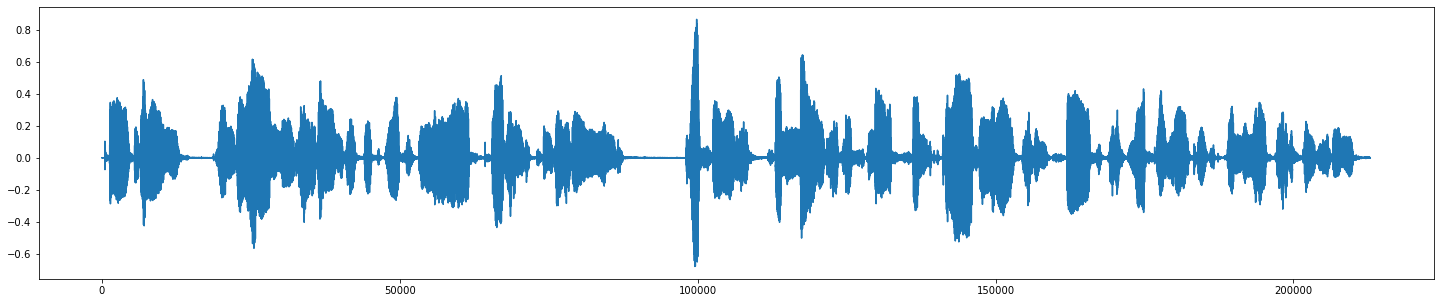

In [8]:
figure = plt.figure(figsize=(25, 5))
print(f"Number of Samples {len(LJSpeech_data[0][0][0])}")
plt.plot(LJSpeech_data[0][0][0])

In [9]:
LJSpeech_data[0][2]

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

In [10]:
Audio(LJSpeech_data[0][0][0], rate=22050)

In [13]:
fn_resample = Resample(orig_freq=22050, new_freq=16000)
resampled = fn_resample(LJSpeech_data[0][0][0])

Number of Samples 154481


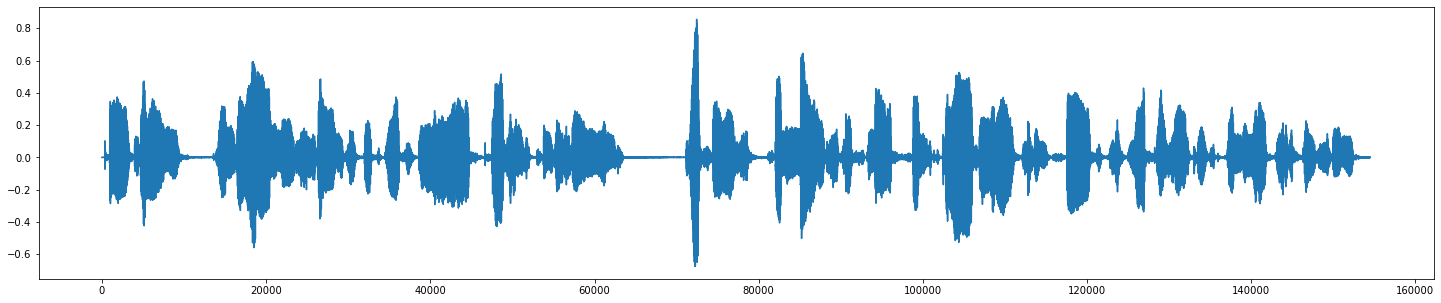

In [14]:
figure = plt.figure(figsize=(25, 5))
print(f"Number of Samples {len(resampled)}")
plt.plot(resampled)

In [15]:
Audio(resampled, rate=16000)

<AxesSubplot:ylabel='Count'>

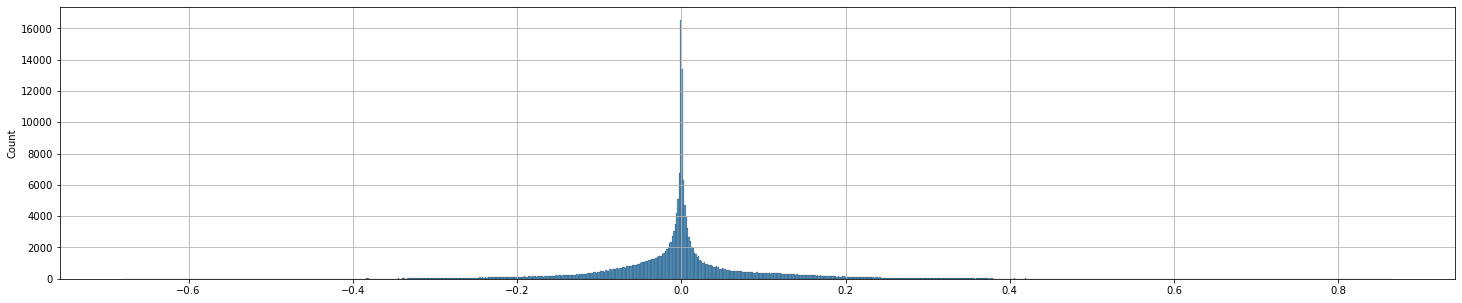

In [20]:
figure = plt.figure(figsize=(25, 5))
plt.grid(True)
sns.histplot(LJSpeech_data[0][0][0])

## MinMaxScaling
scaling in range of [0,1]

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(resampled.reshape(-1, 1)).reshape(-1)

Number of Samples 154481


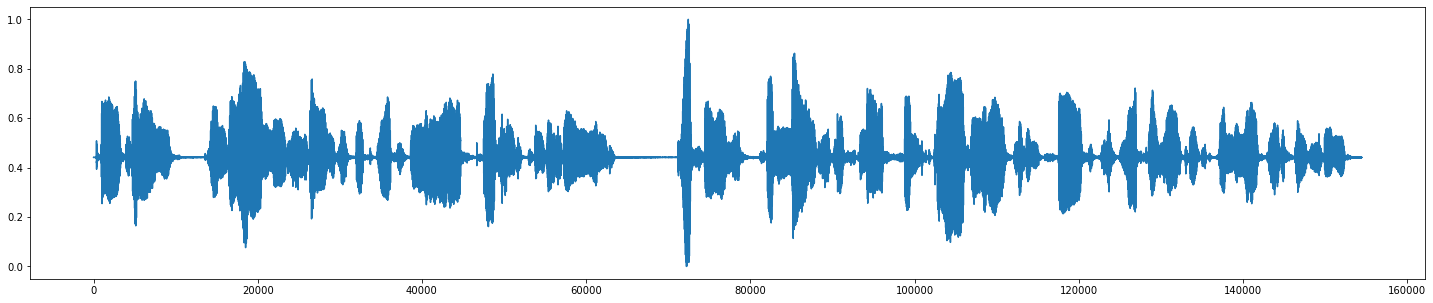

In [34]:
figure = plt.figure(figsize=(25, 5))
print(f"Number of Samples {len(scaled)}")
plt.plot(scaled)

In [35]:
Audio(scaled, rate=16000)

## Train, validation and test data

In [151]:
len_data = len(LJSpeech_data)
train_data_perc = 0.6
val_data_perc = 0.2
test_data_perc = 0.2
train_data, val_data, test_data  = random_split(LJSpeech_data, 
                                                (int(train_data_perc*len_data),
                                                 int(val_data_perc*len_data),
                                                 int(test_data_perc*len_data))
                                               )

In [152]:
train_data[0]

(tensor([[-1.5259e-04,  0.0000e+00, -9.1553e-05,  ..., -3.0518e-04,
          -1.4648e-03,  9.1553e-05]]),
 22050,
 'One wound, approximately one-fourth of an inch by five-eighths of an inch (6 by 15 millimeters),',
 'One wound, approximately one-fourth of an inch by five-eighths of an inch (six by fifteen millimeters),')

In [153]:
class SpeechData(Dataset):
    def __init__(self, data):
        self.data = data
        self.resample = Resample(orig_freq=22050, new_freq=16000)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {"audio" : self.resample(self.data[idx][0][0]),
         "length" : len(self.resample(self.data[idx][0][0])),
         "transcript" : self.data[idx][3]}
        

In [154]:
train_data = SpeechData(train_data)
val_data = SpeechData(val_data)
test_data = SpeechData(test_data)

In [155]:
train_data

In [156]:
len_ = []
for data in tqdm(train_data, total=len(train_data)):
    len_+=[data['length']]

 13%|█▎        | 1049/7860 [00:05<00:37, 180.74it/s]


KeyboardInterrupt: 

In [450]:
max(len_)

161540

In [189]:
def collate_fn(batch):
    length = [data['length'] for data in batch]
    longest = max(length)
    s = np.stack([np.pad(sample['audio'], (0, longest - len(sample['audio']))) for sample in batch])
    audio = torch.from_numpy(s)
        
    transcript = [process_text(data['transcript']) for data in batch]
    transcript_coded = [[vocab_dic['[START]']]+[vocab_dic[token] for token in text]+[vocab_dic['[END]']] for text in transcript]
    
    return {
        "audio":audio,
        "length":torch.tensor(length),
        "transcript":transcript,
        "transcript_coded":transcript_coded
    }

In [190]:
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=8,
    shuffle=True,
    num_workers=1,
    collate_fn = collate_fn)

val_dataloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=8,
    shuffle=True,
    num_workers=1,
    collate_fn = collate_fn)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=8,
    shuffle=True,
    num_workers=1,
    collate_fn = collate_fn)

In [191]:
batch = next(iter(train_dataloader))

In [192]:
batch['audio'].shape

torch.Size([8, 122902])

In [193]:
batch

{'audio': tensor([[-3.3893e-04, -4.3007e-04, -4.4524e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 3.9914e-05,  1.5167e-04,  7.4285e-05,  ...,  1.5224e-03,
           1.1456e-03,  1.9309e-04],
         [-1.8761e-04, -3.4314e-04, -1.9588e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 8.0141e-04,  5.6140e-04,  1.1835e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.4492e-03,  2.4537e-03,  3.1512e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.5365e-04, -3.1480e-05,  3.5422e-06,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 'length': tensor([ 73304, 122902,  60301,  42282,  74976,  57514,  55285,  30765]),
 'transcript': ['the|soviet|authorities|finally|permitted|oswald|to|remain|in|their|country',
  'often|a|commissioner|had|to|leave|the|bench|because|he|was|himself|a|party|to|the|suit|that|was|sub|judice',
  'these|therefore|may|well|be|called|backboned|animal

# Model

## MaskCNN

In [309]:
class MaskCNN(nn.Module):
    def __init__(self):
        
        super(MaskCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 32, 10, 5)
        self.conv2 = nn.Conv1d(32, 64, 3, 2)
        self.conv3 = nn.Conv1d(64, 128, 3, 2)
        self.conv4 = nn.Conv1d(128, 256, 3, 2)
        self.conv5 = nn.Conv1d(256, 512, 3, 2)
        self.conv6 = nn.Conv1d(512, 512, 2, 2)
        self.conv7 = nn.Conv1d(512, 512, 2, 2)
        self.layernorm = nn.LayerNorm(512)
        self.gelu = nn.GELU()
        
        
    def forward(self, batch):
        
        x = batch['audio'].unsqueeze(1)
        lengths = batch['length']
        
        #N = batch_size, C = num_channels, T = num_time_steps
        N, C, T = x.shape
        
        out_len1 = self._get_sequence_length(self.conv1, lengths)
        x = self.conv1(x)
        
        out_len2 = self._get_sequence_length(self.conv2, out_len1)
        x = self.conv2(x)
        
        out_len3 = self._get_sequence_length(self.conv3, out_len2)
        x = self.conv3(x)
        
        out_len4 = self._get_sequence_length(self.conv4, out_len3)
        x = self.conv4(x)
        
        out_len5 = self._get_sequence_length(self.conv5, out_len4)
        x = self.conv5(x)
        
        out_len6 = self._get_sequence_length(self.conv6, out_len5)
        x = self.conv6(x)
        
        out_len7 = self._get_sequence_length(self.conv7, out_len6).type(torch.int)
        x = self.conv7(x)
        
        x = x.transpose(1,2)
        x = self.layernorm(x)
        x = self.gelu(x)
        return x, self.attention_src_mask(out_len7, x.shape[0], x.shape[1])
    
    def _get_sequence_length(self, module, input_size):
        # added padding length for both sides in input_size
        # dilation factor is applied to (kernel_size - 1) so 1 is added after multiplication 
        # finally 1 is added to total at end to compensate for last kernel
        return (input_size + 2*module.padding[0] - (module.dilation[0]*(module.kernel_size[0]-1) + 1) + 1)/module.stride[0]
    
    def attention_src_mask(self, lengths, N, T):
        att_src_mask = torch.zeros((N, T))
        for idx, length in enumerate(lengths):
            att_src_mask[idx][:length] = 0
            att_src_mask[idx][length:] = 1
        return att_src_mask

In [323]:
mod = MaskCNN()

In [466]:
x, att_src_mask = mod(batch)

In [467]:
x.shape

torch.Size([8, 496, 512])

In [452]:
(((((((((((((161560 - 9)/5 - 2)/2)-2)/2)-2)/2)-2)/2)-1)/2)-1)/2)

503.628125

In [363]:
10.10*1000/20

505.0

In [352]:
att_src_mask.shape

torch.Size([8, 657])

In [354]:
att_src_mask

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

## Attention

In [357]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, embed_dim):
        
        super(SelfAttention, self).__init__()
        
        self.query_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.key_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.value_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        
        self.n_heads = n_heads
        self.head_dim = embed_dim//self.n_heads,
        assert self.head_dim*n_heads==embed_dim, 'embed_dim should be divisible by n_heads'
        
    def forward(self, q, k, v, mask=None):
        
        N, T, D = q.shape
        
        query = self.query_proj(q)
        key = self.key_proj(k)
        value = self.value_proj(v)
        
        query, key, value = map(lambda t:rearrange(t, 'N T (HD) -> N H T D', D=self.head_dim), (query, key, value))
        
        scale_factor = embed_dim**0.5
        
        qk = torch.einsum('N H T D, N H t D-> N H T t', query, key)
        
        if mask:
            qk = qk.masked_fill(mask.unsqueeze(1).unsqueeze(1).repeat(1, self.n_heads, T, 1), float('-inf'))
        
        attention_score = F.softmax(qk/scale_factor, dim=-1)
        
        out = torch.einsum('N H T t , N H t D -> N H T D', attention_score, value)
        
        out = rearrange(out, 'N H T D -> N T (HD)')
        
        out = self.out_proj(out)
        
        return out

In [360]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8, dropout=0.0, forward_factor=4):
        
        super(TransformerBlock, self).__init__()
        
        self.attention_module = SelfAttention(n_heads, embed_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        
        self.ff1 = nn.Linear(embed_dim, forward_factor*embed_dim)
        self.ff2 = nn.Linear(embed_dim*forward_factor, embed_dim)
        
    def forward(self, q, k, v, mask):
        
        out = self.attention_module(q, k, v, mask)
        attention_out = self.dropout(self.layernorm1(out+q))
        
        ff1_out = self.dropout(F.relu(self.ff1(attention_out)))
        ff2_out = self.dropout(self.ff2(ff1_out))
        
        final_out = self.dropout(self.layernorm2(ff2_out + attention_out))
        
        return final_out

In [488]:
class Encoder(nn.Module):
    def __init__(self,
                 embed_dim=512,
                 n_heads=8,
                 dropout=0.0,
                 forward_factor=4,
                 num_encoder_blocks=8,
                 max_len=600):
        
        super(Encoder, self).__init__()
        
        params = {'embed_dim':embed_dim, 'n_heads':n_heads, 'dropout':dropout, 'forward_factor':forward_factor}
        self.num_encoder_blocks = num_encoder_blocks
        self.module_list = nn.ModuleList([TransformerBlock(**params) for i in range(self.num_encoder_blocks)])
        self.pos_embedding = nn.Embedding(max_len, embed_dim_dim)
        
        
    def forward(self, x, src_mask):
        
        N, T, D = x.shape()
        
        pos_embedding = self.pos_embedding(torch.tensor(range(T))).unsqueeze(0).repeat(N, 1, 1)
        
        x = pos_embedding + x
        
        for module in self.module_list:
            x = module(x, x, x, src_mask)
            
        return x
            

In [487]:
class DecoderBlock(nn.Module):
    def __init__(self,
                 embed_dim=512,
                 n_heads=8,
                 dropout=0.0,
                 forward_factor=4):
        
        super(DecoderBlock, self).__init__()
        
        self.self_attention = SelfAttention(n_heads, embed_dim)
        self.tranformer_block = TransformerBlock(embed_dim, n_heads, dropout, forward_factor)
        self.layernorm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x, encoder_out, src_mask):
        
        N, T, D = x.shape()
        
        tgt_mask = torch.ones(T, T).triu()-torch.eye(T)
        
        masked_attention = self.self_attention(x, x, x, tgt_mask)
        
        query = self.dropout(self.layernorm(masked_attention + x))
        
        decoder_out = self.tranformer_block(query, encoder_out, encoder_out, src_mask)
        
        return decoder_out

In [500]:
class Decoder(nn.Module):
    def __init__(self,
                 embed_dim=512,
                 n_heads=8,
                 dropout=0.0,
                 forward_factor=4,
                 num_decoder_block=8,
                 max_len=100,
                 tgt_vocab=[]):
        
        super(Decoder, self).__init__()
    
        self.num_decoder_block = num_decoder_block
        params = {'embed_dim':embed_dim, 'n_heads':n_heads, 'dropout':dropout, 'forward_factor':forward_factor}
        self.modulelist = nn.ModuleList([DecoderBlock(**params) for i in range(self.num_decoder_block)])
        self.pos_embedding = nn.Embedding(max_len, embed_dim)
        self.token_embedding = nn.Embedding(len(tgt_vocab), embed_dim)
        
    def forward(self, x, encoder_out, src_mask):
        
        x = self.token_embedding(x)
        
        N, T, D = x.shape()
        
        pos_embedding = self.pos_embedding(torch.tensor(range(T))).unsqueeze(0).repeat(N, 1, 1)
        
        x = pos_embedding + x
        
        for module in self.modulelist:
            x = module(x, encoder_out, src_mask)
        
        return x

### Layernorm

In [185]:
x = torch.randn(2, 5, 4) # N*T*E
x

tensor([[[-0.2590, -0.1481, -0.7224, -0.1802],
         [-0.6968, -0.6850,  1.0154, -0.4015],
         [ 0.0060, -1.9321,  0.1092, -0.4249],
         [-1.2071,  0.0225, -0.1624,  2.9825],
         [ 0.1109,  1.1186, -1.0193, -0.2906]],

        [[ 1.0850,  1.0858,  0.2724,  0.4569],
         [ 0.9637,  0.7904,  0.2677, -0.2574],
         [ 0.8758, -0.2591, -1.0699, -1.3536],
         [ 0.2977, -0.3526,  0.3513, -0.8500],
         [-0.3903, -0.8731,  1.8137,  1.7071]]])

In [164]:
(x - x.mean(axis=-1, keepdim=True))/torch.sqrt(x.var(axis=-1, keepdim=True, unbiased=False))

tensor([[[ 1.4489,  0.0743, -1.3678, -0.1555],
         [-1.0033,  1.6352, -0.0709, -0.5610],
         [ 0.9817, -0.1852, -1.5569,  0.7604],
         [-0.0398,  1.4526, -0.0393, -1.3736],
         [-0.8018,  1.7139, -0.4989, -0.4133]],

        [[ 0.7841,  0.6088, -1.7075,  0.3147],
         [-0.0165,  0.9251,  0.7143, -1.6229],
         [ 0.3563, -0.6020,  1.4420, -1.1964],
         [ 1.1548, -0.6916, -1.2516,  0.7884],
         [-0.6588, -1.2292,  1.3133,  0.5747]]])

In [165]:
layer_norm = nn.LayerNorm(4)
layer_norm(x)

tensor([[[ 1.4488,  0.0743, -1.3677, -0.1555],
         [-1.0033,  1.6351, -0.0709, -0.5610],
         [ 0.9816, -0.1852, -1.5568,  0.7604],
         [-0.0398,  1.4526, -0.0393, -1.3736],
         [-0.8018,  1.7139, -0.4989, -0.4132]],

        [[ 0.7840,  0.6087, -1.7075,  0.3147],
         [-0.0165,  0.9251,  0.7143, -1.6229],
         [ 0.3563, -0.6019,  1.4420, -1.1963],
         [ 1.1548, -0.6916, -1.2516,  0.7884],
         [-0.6588, -1.2291,  1.3133,  0.5747]]],
       grad_fn=<NativeLayerNormBackward0>)

In [158]:
layer_norm.weight

Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)

In [159]:
layer_norm.bias

Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)